<a href="https://colab.research.google.com/github/ZaKSa/neural-networks-8semester-/blob/marathon/%D0%97%D0%B0%D1%86%D0%B5%D0%BF%D0%B8%D0%BD%D0%B0_10_%D0%A0%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_dropout_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Зацепина 6407

1. Сделано

2. Нет

3. Сделано

**Реализовать алгоритм обратного dropout для задачи классификации MNIST из предыдущего задания (для двух видов градиентного спуска):**

На этапе обучения сети (прямое распространение):

  1. генерируете случайную маску из нулей и единиц для слоя layer_1 с вероятностью p=0.5(можно использовать np.random.randint), либо найдите функцию для распределения Бернулли (биномиальное распределение)
  2. Умножаете выход слоя layer_1 на маску
  3. Умножаете  результат в пункте 2 на 1/(1-p)

  4. учесть применение слоя дропаут при обратном распространении сети


  На этапе тестирования сети:

  5. Обычное прямое распространение без dropout. Все как и раньше. 



In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

images = x_train[0:1000]
labels = y_train[0:1000]



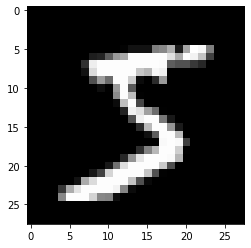

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[0], cmap='gray')

Метрика качества accuracy
Функция потерь используется в процессе оптимизации. Должна быть непрерывной и почти всюду непривычно дифференцируемой
Accuracy не дифференцируема, поэтому не используем на этапе оптимизации(особенность задачи классификации). 

Проблема переобучения - сеть обучалась слишком долго и научилась распознавать шум на обсучающем наборе данных, а не принимать решение на основе полезного сигнала. Шум-дополнительрые объекты, не имеющие отношения к целевой переменной
Как бороться? Вовремя остановить обучение - достигает локального минимума на графике функции потерь или когда точность на тестовой выборке начнет падать - это метод ранней остановки
Точность не на тестовой выборке лучше, а на валидационной

Делим набор данных на обучающую, валидационную и тестовую выборку. На валидационной считаем точность в процессе обучения, а тестовую используем только один раз: после обучения для финальной оценки работы модели. 


In [ ]:
import sys, numpy as np
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

images, labels = (x_train[0:1000].reshape(1000,28*28) / 255, y_train[0:1000])

one_hot_labels = np.zeros((len(labels),10))
for i,l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

test_images = x_test.reshape(len(x_test),28*28) / 255
test_labels = np.zeros((len(y_test),10))
for i,l in enumerate(y_test):
    test_labels[i][l] = 1

np.random.seed(1)
relu = lambda x:(x>=0) * x # returns x if x > 0, return 0 otherwise
relu2deriv = lambda x: x>=0 # returns 1 for input > 0, return 0 otherwise
learning_rate, iterations, hidden_size, pixels_per_image, num_labels = (0.005, 350, 40, 784, 10)

weights_0_1 = 0.2*np.random.random((pixels_per_image,hidden_size)) - 0.1
weights_1_2 = 0.2*np.random.random((hidden_size,num_labels)) - 0.1

p=0.5
error_train=[]
correct_cnt_train=[]

error_test=[]
correct_cnt_test=[]

iteration=[]

for j in range(iterations):
    error, correct_cnt = (0.0, 0)
    
    for i in range(len(images)):
        layer_0 = images[i:i+1]
        layer_1 = relu(np.dot(layer_0,weights_0_1))

        #Реализовать слой дропаут. Отключить 50% узлов после скрытого слоя- вероятность 0.5. Умножить значение слоя layer1 на случайную маску из нулей и единиц. Получится эффект выключения случайных цзлов в layer1. Путем записи нцлей на места случайных элементов
        #dropout(прореживание)-способ регуляризации. Заключается в отключении случайных нейронов сети(сеть учится на случайном подмножестве нейронов), 
        #сеть становиться меньше, значит меньше подвержена переобучению
        mask=np.random.randint(2, size=hidden_size) #генерируем случайную маску из 0 и 1

        layer_1*=mask
        layer_1*=1/(1-p)

        layer_2 = np.dot(layer_1,weights_1_2)

        error += np.sum((labels[i:i+1] - layer_2) ** 2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1]))

        layer_2_delta = (labels[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T)* relu2deriv(layer_1)

        weight_1_2_corrections = layer_1.T.dot(layer_2_delta)
        weight_0_1_corrections = layer_0.T.dot(layer_1_delta)
        


        weights_1_2 += learning_rate * weight_1_2_corrections
        weights_0_1 += learning_rate * weight_0_1_corrections 
        

    sys.stdout.write("\r I:"+str(j)+ \
                     " Train-Err:" + str(error/float(len(images)))[0:5] +\
                     " Train-Acc:" + str(correct_cnt/float(len(images))))
    
    
    if(j % 10 == 0 or j == iterations-1):
        iteration.append(j)
        error_train.append(error/len(images))
        correct_cnt_train.append(correct_cnt/len(images))

        error, correct_cnt = (0.0, 0)

        for i in range(len(test_images)): #тестирование сети-без dropout

            layer_0 = test_images[i:i+1]
            layer_1 = relu(np.dot(layer_0,weights_0_1))
            layer_2 = np.dot(layer_1,weights_1_2)

            error += np.sum((test_labels[i:i+1] - layer_2) ** 2)
            correct_cnt += int(np.argmax(layer_2) == \
                                            np.argmax(test_labels[i:i+1]))            
        
        sys.stdout.write(" Test-Err:" + str(error/float(len(test_images)))[0:5] +\
                         " Test-Acc:" + str(correct_cnt/float(len(test_images))))
        
        error_test.append(error/len(test_images))
        correct_cnt_test.append(correct_cnt/len(test_images))

        print()

 I:0 Train-Err:0.863 Train-Acc:0.332 Test-Err:0.649 Test-Acc:0.6072
 I:10 Train-Err:0.585 Train-Acc:0.629 Test-Err:0.473 Test-Acc:0.7585
 I:20 Train-Err:0.548 Train-Acc:0.699 Test-Err:0.442 Test-Acc:0.7785
 I:30 Train-Err:0.544 Train-Acc:0.683 Test-Err:0.445 Test-Acc:0.7186
 I:40 Train-Err:0.554 Train-Acc:0.684 Test-Err:0.415 Test-Acc:0.7971
 I:50 Train-Err:0.541 Train-Acc:0.7 Test-Err:0.438 Test-Acc:0.7524
 I:60 Train-Err:0.555 Train-Acc:0.715 Test-Err:0.458 Test-Acc:0.6997
 I:70 Train-Err:0.551 Train-Acc:0.697 Test-Err:0.455 Test-Acc:0.7205
 I:80 Train-Err:0.574 Train-Acc:0.692 Test-Err:0.428 Test-Acc:0.75
 I:90 Train-Err:0.561 Train-Acc:0.691 Test-Err:0.432 Test-Acc:0.7783
 I:100 Train-Err:0.572 Train-Acc:0.694 Test-Err:0.469 Test-Acc:0.7293
 I:110 Train-Err:0.554 Train-Acc:0.717 Test-Err:0.441 Test-Acc:0.7631
 I:120 Train-Err:0.583 Train-Acc:0.692 Test-Err:0.515 Test-Acc:0.7299
 I:130 Train-Err:0.578 Train-Acc:0.7 Test-Err:0.509 Test-Acc:0.7469
 I:140 Train-Err:0.579 Train-Acc:0.70

 График обучения сети

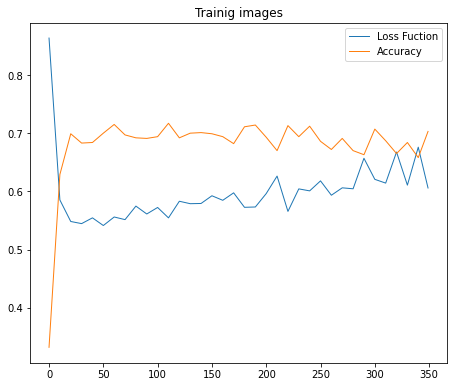

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 10), constrained_layout=True)
ax1 = fig.add_subplot(221)
ax1.plot(iteration, error_train, linewidth = 1, label="Loss Fuction")

ax1.plot(iteration, correct_cnt_train, linewidth = 1, label="Accuracy")
ax1.set_title("Trainig images")
ax1.legend()

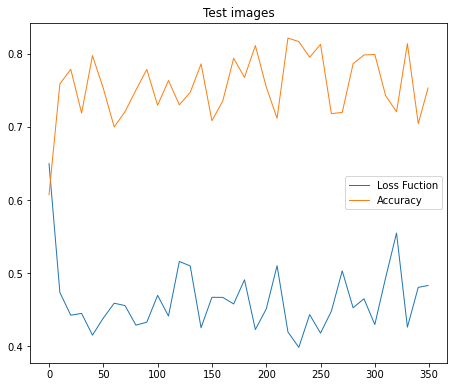

In [ ]:
fig2 = plt.figure(figsize=(12, 10), constrained_layout=True)
ax2 = fig2.add_subplot(221)

ax2.plot(iteration, error_test, linewidth = 1, label="Loss Fuction")

ax2.plot(iteration, correct_cnt_test, linewidth = 1, label="Accuracy")
ax2.set_title("Test images")
ax2.legend()

In [ ]:
import numpy as np
np.random.seed(1)

def relu(x):
    return (x >= 0) * x # returns x if x > 0

def relu2deriv(output):
    return output >= 0 # returns 1 for input > 0

batch_size = 50
learning_rate, iterations = (0.001, 300)
pixels_per_image, num_labels, hidden_size = (784, 10, 100)

weights_0_1 = 0.2*np.random.random((pixels_per_image,hidden_size)) - 0.1
weights_1_2 = 0.2*np.random.random((hidden_size,num_labels)) - 0.1


p=0.5
error_train=[]
correct_cnt_train=[]

error_test=[]
correct_cnt_test=[]

iteration=[]

for j in range(iterations):
    error, correct_cnt = (0.0, 0)
    for i in range(int(len(images) / batch_size)):
        batch_start, batch_end = ((i * batch_size),((i+1)*batch_size))

        layer_0 = images[batch_start:batch_end]
        layer_1 = relu(np.dot(layer_0,weights_0_1))    

        mask=np.random.randint(2, size=(batch_size, hidden_size)) #генерируем случайную маску из 0 и 1
        layer_1*=mask
        layer_1*=1/(1-p)

        layer_2 = np.dot(layer_1,weights_1_2)

        error += np.sum((labels[batch_start:batch_end] - layer_2) ** 2)
        for k in range(batch_size):
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == np.argmax(labels[batch_start+k:batch_start+k+1]))

            layer_2_delta = (labels[batch_start:batch_end]-layer_2)/batch_size
            layer_1_delta = layer_2_delta.dot(weights_1_2.T)* relu2deriv(layer_1)
            weight_1_2_corrections = layer_1.T.dot(layer_2_delta)
            weight_0_1_corrections = layer_0.T.dot(layer_1_delta)
            
            weights_1_2 += learning_rate * weight_1_2_corrections
            weights_0_1 += learning_rate * weight_0_1_corrections
            
    if(j%10 == 0):
        iteration.append(j)
        error_train.append(error/len(images))
        correct_cnt_train.append(correct_cnt/len(images))

        test_error = 0.0
        test_correct_cnt = 0

        for i in range(len(test_images)):
            layer_0 = test_images[i:i+1]
            layer_1 = relu(np.dot(layer_0,weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)

            test_error += np.sum((test_labels[i:i+1] - layer_2) ** 2)
            test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))

        sys.stdout.write("\n" + \
                         "I:" + str(j) + \
                         " Test-Err:" + str(test_error/ float(len(test_images)))[0:5] +\
                         " Test-Acc:" + str(test_correct_cnt/ float(len(test_images)))+\
                         " Train-Err:" + str(error/ float(len(images)))[0:5] +\
                         " Train-Acc:" + str(correct_cnt/ float(len(images))))
        error_test.append(test_error/len(test_images))
        correct_cnt_test.append(test_correct_cnt/len(test_images))


I:0 Test-Err:0.760 Test-Acc:0.4808 Train-Err:1.266 Train-Acc:0.2
I:10 Test-Err:0.506 Test-Acc:0.7519 Train-Err:0.556 Train-Acc:0.71
I:20 Test-Err:0.458 Test-Acc:0.7811 Train-Err:0.504 Train-Acc:0.755
I:30 Test-Err:0.428 Test-Acc:0.8052 Train-Err:0.470 Train-Acc:0.776
I:40 Test-Err:0.413 Test-Acc:0.8161 Train-Err:0.449 Train-Acc:0.793
I:50 Test-Err:0.403 Test-Acc:0.8194 Train-Err:0.452 Train-Acc:0.784
I:60 Test-Err:0.398 Test-Acc:0.8271 Train-Err:0.443 Train-Acc:0.811
I:70 Test-Err:0.392 Test-Acc:0.8245 Train-Err:0.436 Train-Acc:0.809
I:80 Test-Err:0.386 Test-Acc:0.8305 Train-Err:0.432 Train-Acc:0.81
I:90 Test-Err:0.386 Test-Acc:0.8239 Train-Err:0.421 Train-Acc:0.818
I:100 Test-Err:0.382 Test-Acc:0.8267 Train-Err:0.427 Train-Acc:0.815
I:110 Test-Err:0.395 Test-Acc:0.8118 Train-Err:0.436 Train-Acc:0.801
I:120 Test-Err:0.399 Test-Acc:0.8163 Train-Err:0.431 Train-Acc:0.815
I:130 Test-Err:0.402 Test-Acc:0.8065 Train-Err:0.426 Train-Acc:0.822
I:140 Test-Err:0.397 Test-Acc:0.801 Train-Err:0.

Постройте графики функции потерь и accuracy для двух выборок.

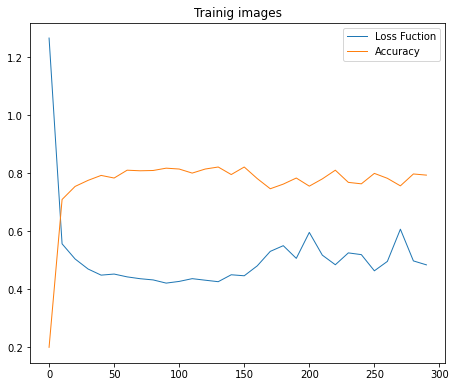

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 10), constrained_layout=True)
ax1 = fig.add_subplot(221)
ax1.plot(iteration, error_train, linewidth = 1, label="Loss Fuction")

ax1.plot(iteration, correct_cnt_train, linewidth = 1, label="Accuracy")
ax1.set_title("Trainig images")
ax1.legend()

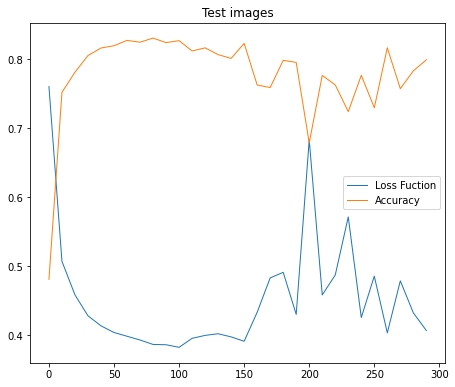

In [ ]:
fig2 = plt.figure(figsize=(12, 10), constrained_layout=True)
ax2 = fig2.add_subplot(221)

ax2.plot(iteration, error_test, linewidth = 1, label="Loss Fuction")

ax2.plot(iteration, correct_cnt_test, linewidth = 1, label="Accuracy")
ax2.set_title("Test images")
ax2.legend()

Можно ли поставить слой дропаут после выходного слоя? 

Нет, тогда просто наш выходный вектор - результат - получит в 50% неверные значения выходного слоя. Здесь прореживание не нужно